In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

#np.random.seed(4); #same set of numbers will appear every time
#np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.80; # 80% to train, includes validation
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 1 # output slice size
halo = 15 # edge cells
ts = os + halo * 2 # total input slice size including halos 31 and overlap30 pixels
ks = int(6) # kernel size 6
l2r = 4066; # number of slices in one profile; 15 halo size on each side ;4066+15+15=4096



In [4]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 

#cut each profile into 4066 slices. 
#label: tau channel of the center of each slice(reduced domain)
for i in range(num):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (16264000, 31, 3) whole dataset label size:  (16264000, 1)


In [5]:
predictions = np.empty((test_size,1)) 
predictions.shape

(800, 1)

In [6]:
# CNN over domain -------------------------------------------


def evaluate_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    bsize = 1024
    eps = 500
    
    model_m = models.Sequential()
    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.Conv1D(nchan*80, kernel_size=4, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Conv1D(8, kernel_size=1)) 
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 1

    model_m.summary()


    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,tf.keras.metrics.RootMeanSquaredError()])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse = results[2]

    return model_m,rmse,mse,history,predictions

In [7]:
#5 folds cross validation 

n_folds=5
kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)


KFold(n_splits=5, random_state=None, shuffle=False)


In [8]:
ratio

3252800

In [9]:
cv_scores= list()
cv_scores2=list()
model_history=list()

count=1
for train_index, test_index in kf.split(image):

    print("TRAIN:", train_index, "TEST:", test_index)
    train_image, test_image = image[train_index], image[test_index]
    train_label, test_label = label[train_index], label[test_index]

    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(count)+' : '+str(mse))
    print('RMSE on test set in fold'+str(count)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

    count+=1
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 300)           5700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 240)           288240    
_________________________________________________________________
dropout (Dropout)            (None, 23, 240)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 8)             1928      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 8)             0         
_________________________________________________________________
flatten (Flatten)            (None, 184)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

11118/11118 [==============================] - 142s 13ms/step - loss: 6.1819 - mean_squared_error: 6.1819 - root_mean_squared_error: 2.4863 - val_loss: 5.3250 - val_mean_squared_error: 5.3250 - val_root_mean_squared_error: 2.3076
Epoch 62/500
11118/11118 [==============================] - 141s 13ms/step - loss: 6.1212 - mean_squared_error: 6.1212 - root_mean_squared_error: 2.4741 - val_loss: 5.4485 - val_mean_squared_error: 5.4485 - val_root_mean_squared_error: 2.3342
Epoch 63/500
11118/11118 [==============================] - 141s 13ms/step - loss: 6.1312 - mean_squared_error: 6.1312 - root_mean_squared_error: 2.4761 - val_loss: 5.3440 - val_mean_squared_error: 5.3440 - val_root_mean_squared_error: 2.3117
Epoch 64/500
11118/11118 [==============================] - 140s 13ms/step - loss: 6.0902 - mean_squared_error: 6.0902 - root_mean_squared_error: 2.4678 - val_loss: 5.2171 - val_mean_squared_error: 5.2171 - val_root_mean_squared_error: 2.2841
Epoch 65/500
11118/11118 [===============

11118/11118 [==============================] - 141s 13ms/step - loss: 5.4722 - mean_squared_error: 5.4722 - root_mean_squared_error: 2.3392 - val_loss: 4.9257 - val_mean_squared_error: 4.9257 - val_root_mean_squared_error: 2.2194
Epoch 128/500
11118/11118 [==============================] - 140s 13ms/step - loss: 5.4493 - mean_squared_error: 5.4493 - root_mean_squared_error: 2.3344 - val_loss: 4.7752 - val_mean_squared_error: 4.7752 - val_root_mean_squared_error: 2.1852
Epoch 129/500
11118/11118 [==============================] - 141s 13ms/step - loss: 5.4696 - mean_squared_error: 5.4696 - root_mean_squared_error: 2.3387 - val_loss: 5.1156 - val_mean_squared_error: 5.1156 - val_root_mean_squared_error: 2.2618
Epoch 130/500
11118/11118 [==============================] - 140s 13ms/step - loss: 5.4239 - mean_squared_error: 5.4239 - root_mean_squared_error: 2.3289 - val_loss: 4.6315 - val_mean_squared_error: 4.6315 - val_root_mean_squared_error: 2.1521
Epoch 131/500
11118/11118 [===========

11118/11118 [==============================] - 141s 13ms/step - loss: 5.1523 - mean_squared_error: 5.1523 - root_mean_squared_error: 2.2699 - val_loss: 4.4469 - val_mean_squared_error: 4.4469 - val_root_mean_squared_error: 2.1088
Epoch 194/500
11118/11118 [==============================] - 140s 13ms/step - loss: 5.1505 - mean_squared_error: 5.1505 - root_mean_squared_error: 2.2695 - val_loss: 4.7104 - val_mean_squared_error: 4.7104 - val_root_mean_squared_error: 2.1703
Epoch 195/500
11118/11118 [==============================] - 141s 13ms/step - loss: 5.1438 - mean_squared_error: 5.1438 - root_mean_squared_error: 2.2680 - val_loss: 4.7673 - val_mean_squared_error: 4.7673 - val_root_mean_squared_error: 2.1834
Epoch 196/500
11118/11118 [==============================] - 140s 13ms/step - loss: 5.1114 - mean_squared_error: 5.1114 - root_mean_squared_error: 2.2608 - val_loss: 4.7121 - val_mean_squared_error: 4.7121 - val_root_mean_squared_error: 2.1707
Epoch 197/500
11118/11118 [===========

11118/11118 [==============================] - 141s 13ms/step - loss: 8.0415 - mean_squared_error: 8.0415 - root_mean_squared_error: 2.8357 - val_loss: 7.2385 - val_mean_squared_error: 7.2385 - val_root_mean_squared_error: 2.6904
Epoch 16/500
11118/11118 [==============================] - 141s 13ms/step - loss: 7.9496 - mean_squared_error: 7.9496 - root_mean_squared_error: 2.8195 - val_loss: 6.6918 - val_mean_squared_error: 6.6918 - val_root_mean_squared_error: 2.5869
Epoch 17/500
11118/11118 [==============================] - 141s 13ms/step - loss: 7.8370 - mean_squared_error: 7.8370 - root_mean_squared_error: 2.7994 - val_loss: 6.7316 - val_mean_squared_error: 6.7316 - val_root_mean_squared_error: 2.5945
Epoch 18/500
11118/11118 [==============================] - 141s 13ms/step - loss: 7.6743 - mean_squared_error: 7.6743 - root_mean_squared_error: 2.7702 - val_loss: 6.5818 - val_mean_squared_error: 6.5818 - val_root_mean_squared_error: 2.5655
Epoch 19/500
11118/11118 [===============

11118/11118 [==============================] - 142s 13ms/step - loss: 5.6324 - mean_squared_error: 5.6324 - root_mean_squared_error: 2.3732 - val_loss: 4.6257 - val_mean_squared_error: 4.6257 - val_root_mean_squared_error: 2.1507
Epoch 82/500
11118/11118 [==============================] - 141s 13ms/step - loss: 5.6271 - mean_squared_error: 5.6271 - root_mean_squared_error: 2.3721 - val_loss: 4.5304 - val_mean_squared_error: 4.5304 - val_root_mean_squared_error: 2.1285
Epoch 83/500
11118/11118 [==============================] - 141s 13ms/step - loss: 5.5587 - mean_squared_error: 5.5587 - root_mean_squared_error: 2.3576 - val_loss: 4.6632 - val_mean_squared_error: 4.6632 - val_root_mean_squared_error: 2.1594
Epoch 84/500
11118/11118 [==============================] - 142s 13ms/step - loss: 5.6004 - mean_squared_error: 5.6004 - root_mean_squared_error: 2.3665 - val_loss: 4.5049 - val_mean_squared_error: 4.5049 - val_root_mean_squared_error: 2.1225
Epoch 85/500
11118/11118 [===============

11118/11118 [==============================] - 141s 13ms/step - loss: 4.9335 - mean_squared_error: 4.9335 - root_mean_squared_error: 2.2211 - val_loss: 3.9973 - val_mean_squared_error: 3.9973 - val_root_mean_squared_error: 1.9993
Epoch 148/500
11118/11118 [==============================] - 141s 13ms/step - loss: 4.9446 - mean_squared_error: 4.9446 - root_mean_squared_error: 2.2236 - val_loss: 4.5801 - val_mean_squared_error: 4.5801 - val_root_mean_squared_error: 2.1401
Epoch 149/500
11118/11118 [==============================] - 141s 13ms/step - loss: 4.9099 - mean_squared_error: 4.9099 - root_mean_squared_error: 2.2158 - val_loss: 3.9847 - val_mean_squared_error: 3.9847 - val_root_mean_squared_error: 1.9962
Epoch 150/500
11118/11118 [==============================] - 141s 13ms/step - loss: 4.9474 - mean_squared_error: 4.9474 - root_mean_squared_error: 2.2243 - val_loss: 3.9053 - val_mean_squared_error: 3.9053 - val_root_mean_squared_error: 1.9762
Epoch 151/500
11118/11118 [===========

11118/11118 [==============================] - 142s 13ms/step - loss: 4.5024 - mean_squared_error: 4.5024 - root_mean_squared_error: 2.1219 - val_loss: 3.8174 - val_mean_squared_error: 3.8174 - val_root_mean_squared_error: 1.9538
Epoch 214/500
11118/11118 [==============================] - 140s 13ms/step - loss: 4.5197 - mean_squared_error: 4.5197 - root_mean_squared_error: 2.1259 - val_loss: 3.6706 - val_mean_squared_error: 3.6706 - val_root_mean_squared_error: 1.9159
Epoch 215/500
11118/11118 [==============================] - 140s 13ms/step - loss: 4.5084 - mean_squared_error: 4.5084 - root_mean_squared_error: 2.1233 - val_loss: 3.5401 - val_mean_squared_error: 3.5401 - val_root_mean_squared_error: 1.8815
Epoch 216/500
11118/11118 [==============================] - 140s 13ms/step - loss: 4.5023 - mean_squared_error: 4.5023 - root_mean_squared_error: 2.1218 - val_loss: 3.6889 - val_mean_squared_error: 3.6889 - val_root_mean_squared_error: 1.9206
Epoch 217/500
11118/11118 [===========

11118/11118 [==============================] - 141s 13ms/step - loss: 4.2627 - mean_squared_error: 4.2627 - root_mean_squared_error: 2.0646 - val_loss: 3.5366 - val_mean_squared_error: 3.5366 - val_root_mean_squared_error: 1.8806
Epoch 280/500
11118/11118 [==============================] - 140s 13ms/step - loss: 4.2528 - mean_squared_error: 4.2528 - root_mean_squared_error: 2.0622 - val_loss: 3.5729 - val_mean_squared_error: 3.5729 - val_root_mean_squared_error: 1.8902
Epoch 281/500
11118/11118 [==============================] - 141s 13ms/step - loss: 4.2280 - mean_squared_error: 4.2280 - root_mean_squared_error: 2.0562 - val_loss: 3.3975 - val_mean_squared_error: 3.3975 - val_root_mean_squared_error: 1.8432
Epoch 282/500
11118/11118 [==============================] - 141s 13ms/step - loss: 4.2336 - mean_squared_error: 4.2336 - root_mean_squared_error: 2.0575 - val_loss: 3.4995 - val_mean_squared_error: 3.4995 - val_root_mean_squared_error: 1.8707
Epoch 283/500
11118/11118 [===========

In [25]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 3.9470 with standard deviation (0.4564)
Estimated RMSE 1.9835 with standard deviation (0.1124)


In [23]:
cv_scores2

[2.037104368209839, 1.8870152235031128, 1.8956, 2.1806, 1.9173]

The optimal number of epochs is 125


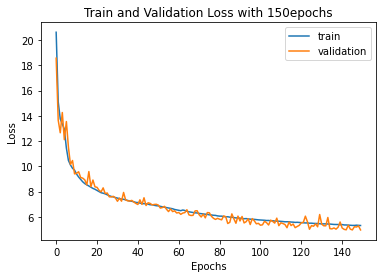

In [19]:
patience=25
# plot training and validation history in the last fold
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience)+' in the last fold.')